# Data Science Lab, Ex 2

## Question 1

### (a) Handling null values

In [96]:
import pandas as pd
import numpy as np
crimes_df = pd.read_csv('ex1.csv')

In the previous homework, we looked at the state column which had quite alot of null values (they were referenced as '-1' values), and since we noticed that the **city_or_county** column had a much less null value rate, we were able to assume the state of many cities depending on the similar values in the **city_or_county** column.

This demonstrates how effective it is to complete features from other dependent features.

We did that by doing the following

In [97]:
crimes_df.state.replace('-1',np.nan,inplace=True)
crimes_df.state = crimes_df.sort_values(by='city_or_county').groupby('city_or_county')['state'].apply(lambda x : x.ffill().bfill())

And now, if we check the value of "-1" in the state column, we'll get 0

In [98]:
crimes_df['state'].eq('-1').sum()

0

For now, we'll pick a continious non-categorical feature, and try and work out on filling the null values in a smart way.

Looking at the data set, the only two continious data that we have are **longitude** and **latitude**, and if we check, we can see that they both contain a good amount of null values.

In [99]:
crimes_df[['longitude','latitude']].isnull().sum()

longitude    775
latitude     629
dtype: int64

We'll try fixing up the **longitude** by imputating these null values in different ways.

After trying to imputate the values depending on the address, and then the country+address, and failing spactacularly (the null values somehow increased instead of decreasing :|)

I came to the conclusion that it would be best to imputate depending on the mean of the logitude in the **city_or_county**.

In [104]:
crimes_df['longitude'].fillna(crimes_df['longitude'].mean(), inplace=True)

And just to make sure that the null values have been filled

In [105]:
crimes_df['longitude'].isna().sum()

0

Very nice.

### (b) Binning features

Let's reload the dataset as new, and look at the cardinality of each column

In [18]:
crimes = pd.read_csv('ex1.csv')
for column in crimes.columns:
    print(column, crimes[column].value_counts().count())

Unnamed: 0 23967
incident_id 23967
date 1571
state 103
city_or_county 4175
address 21625
n_killed 11
n_injured 21
congressional_district 54
gun_stolen 116
gun_type 491
incident_characteristics 3705
latitude 16038
location_description 3455
longitude 20785
n_guns_involved 48
notes 14739
participant_age 3452
participant_age_group 248
participant_gender 251
participant_name 11560
participant_relationship 106
participant_status 590
participant_type 115
state_house_district 213
state_senate_district 67


I decided to create a binning strategy on the feature **gun_stolen**, it contains information about **each** gun that was used in the crime - whether it was stolen or not, and it's parsed in a very unintuitive way, I believe that turning the feature into a 2-categorical value feature that contains whether a gun in the crime was stolen or not, will give us a more comfortable look at the data, and make it more organized.

This way, we can look as well on the amount of crimes that contained a gun that is stolen.

In [20]:
crimes['gun_stolen'].value_counts()

0::Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        12125
0::Unknown||1::Unknown                                                                                                                                                                                                                                                                                                                                          

We can see the complication of the values in the feature, let's bin the different values together.

In [22]:
crimes['gun_stolen'] = crimes['gun_stolen'].apply(lambda x : str(x).count("Stolen")).astype(bool)

And looking at the data

In [23]:
crimes[['incident_id', 'gun_stolen']]

,incident_id,gun_stolen
0,137007,False
1,49807,False
2,2318,False
3,237635,False
4,238068,True
...,...,...
23962,45255,False
23963,157269,False
23964,197544,False
23965,213943,False


We can clearly see if a stolen gun was used in the crime

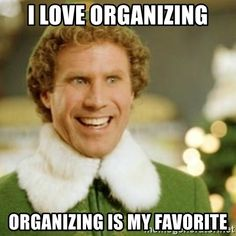

## Question 2

### (a) Useful features

I would add the following features that i think would provide a more in-depth look
- A categocrical feature that describes the time of the year - that is if there was something significant in the timing, a holiday, elections ,etc, i believe it could give us an insight if crime was more or less in the specific period.
- An another categorical feature that contains whether the cause of the crime (person or object) has been caught or apprehended, or dealt with, this feature can help us see the rate of crime solving by location or forces in places.
- (might be considered a bit racist, but my intentions are scientific) a feature that holds the ethnicity of the suspect or killer, this can give us an insight on the amount of crime in the different ethnic groups.

### (b) Adding a new feature from an external dataset

I chose the elections data from 2016, I decided to merge the city/county column and it's political orientation, as this will help us see the rates of crimes in Democratic or Liberal cities, and in cities or states that have mixed political wings.

Let's open both data and have a look

In [2]:
df = pd.read_csv("ex2.csv")
election_df = pd.read_csv("election_results.csv")

In [3]:
election_df

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003.0,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003.0,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005.0,Democrat,Bernie Sanders,222,0.078
...,...,...,...,...,...,...,...,...
24606,Wyoming,WY,Teton-Sublette,95600028.0,Republican,Ted Cruz,0,0.000
24607,Wyoming,WY,Uinta-Lincoln,95600027.0,Republican,Donald Trump,0,0.000
24608,Wyoming,WY,Uinta-Lincoln,95600027.0,Republican,John Kasich,0,0.000
24609,Wyoming,WY,Uinta-Lincoln,95600027.0,Republican,Marco Rubio,0,0.000


We can see the results for each county in the column ***party***, let's do a few modifications on the ***election_df*** and merge the two.

In [4]:
election_df = election_df[["county", "party"]].drop_duplicates().rename(columns={"county" : "city_or_county"})
election_df

,city_or_county,party
0,Autauga,Democrat
2,Baldwin,Democrat
4,Barbour,Democrat
6,Bibb,Democrat
8,Blount,Democrat
...,...,...
24591,Laramie,Republican
24595,Sheridan-Big Horn,Republican
24599,Sweetwater-Carbon,Republican
24603,Teton-Sublette,Republican


In [5]:
merged_data = pd.merge(df, election_df, on="city_or_county",how="left")
merged_data

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district,party
0,194704,877945,2017-06-25,California,Humboldt County (county),NaN,0,0,2.0,0::Unknown,...,NaN,0::Adult 18+,NaN,0::Manuel Robert Alvidrez,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,2.0,2.0,NaN
1,103375,467550,2015-12-15,Georgia,Gwinnett (county),NaN,0,0,7.0,0::Unknown,...,NaN,NaN,0::Male||1::Male,0::Eric Cotto||1::Christopher Anderson,NaN,0::Unharmed,0::Victim||1::Subject-Suspect,102.0,45.0,NaN
2,216952,983151,2017-11-04,North Carolina,Rocky Mount,1000 Block of Niblick Dr,0,0,2.0,0::Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,4.0,NaN
3,140445,626752,2016-08-11,Texas,Odessa,3939 Tanglewood Lane,0,0,11.0,0::Unknown||1::Unknown||2::Unknown||3::Unknown...,...,0::23||1::24,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Female||2::Male||3::Male||4::Male|...,NaN,2::Home Invasion - Perp Does Not Know Victim||...,0::Unharmed||1::Unharmed||2::Unharmed||3::Unha...,0::Victim||1::Victim||2::Subject-Suspect||3::S...,81.0,31.0,NaN
4,72670,349392,2015-05-30,New York,Amityville,"15, 21 Rosewood Avenue",1,2,2.0,NaN,...,0::44||1::38||2::37||3::38,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Louis Wilson||1::Shaun Wilson||2::Junious W...,NaN,0::Killed||1::Injured||2::Injured||3::Unharmed...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,11.0,8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42711,44397,214500,2014-10-31,Washington,Roy,216 McNaught St S,0,0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN
42712,238964,1079004,2018-03-26,Virginia,Newport News,4500 block of Baughman Ct,0,1,3.0,0::Unknown,...,0::21,0::Adult 18+,0::Male||1::Male,NaN,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,95.0,2.0,Democrat
42713,238964,1079004,2018-03-26,Virginia,Newport News,4500 block of Baughman Ct,0,1,3.0,0::Unknown,...,0::21,0::Adult 18+,0::Male||1::Male,NaN,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,95.0,2.0,Republican
42714,169777,823447,2017-02-01,Oklahoma,Tulsa,N Birmingham Ave and E Woodrow Pl,0,0,1.0,0::Unknown,...,0::26,0::Adult 18+,0::Male,0::Adrian Jebree Sample,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,72.0,11.0,Democrat


In the last column, we can see the political party of the city/county, if one was found was found in the ***election_df***, i chose ***left*** inner join as to keep our original data, even if no match for a political party was found.

## Question 3

## (a) Adding aggregative functions

I'll add two features using aggregation which i think would be useful for the feature set

- the effectiveness of law enforcements in tracking the suspects down - we'll measure this feature by adding two features (we'll do that real quick) ***no_of_suspects*** and ***suspects_arrested*** in each crime, these will allow us to measure how well the law enforcement performed in apprehending the crime suspects.

- same, but state-wise

I decided to add them as I believe that these features will allow us to have a better look on the severity of crimes in each county and the effectiveness of law enforcement.

Let's add the first feature using aggregation, but before we do that we need to think of how would we recognize that a crime's suspect has been apprehended, and the number of suspects that participated in the crime, one particular column in the data ***participant_status***, contains info about every subject in the crime, and we can check there for starters to get a clue of whether the suspect(s) has been apprehended.

In [6]:
df['participant_status'].value_counts()

0::Injured                                                                                                            5287
0::Unharmed, Arrested                                                                                                 3188
0::Killed                                                                                                             2673
0::Injured||1::Unharmed                                                                                               1590
0::Unharmed                                                                                                           1370
                                                                                                                      ... 
0::Injured||1::Injured||2::Injured||3::Injured||4::Injured||5::Injured||6::Injured, Arrested||7::Injured, Arrested       1
0:Injured|1:Unharmed, Arrested|2:Unharmed, Arrested|3:Unharmed, Arrested                                                 1
0::Unharmed||1::

In principal, we can check whether this column contains an 'Arrested' keyword, and it could give us an indicatation of whether the suspect has been apprehended, as the only type of people that are arrested are suspects (can be debated, but it's enough for this purpose).

And we can do that same thing for the ***participant_type*** column, by checking the count of "Suspect".

In [7]:
df['participant_type'].value_counts()

0::Victim                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       7361
0::Victim||1::Subject-Suspect                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   628

In [8]:
df['no_of_suspects'] = df['participant_type'].apply(lambda x: str(x).count("Suspect"))

In [9]:
df[['participant_type', 'no_of_suspects']]

,participant_type,no_of_suspects
0,0::Subject-Suspect,1
1,0::Victim||1::Subject-Suspect,1
2,NaN,0
3,0::Victim||1::Victim||2::Subject-Suspect||3::S...,5
4,0::Victim||1::Victim||2::Victim||3::Subject-Su...,1
...,...,...
29995,0::Subject-Suspect,1
29996,0::Subject-Suspect,1
29997,NaN,0
29998,0::Victim||1::Subject-Suspect,1


In [10]:
df['suspects_arrested'] = df['participant_status'].agg(lambda x: str(x).count("Arrested"))

In [11]:
df[['participant_status','suspects_arrested']]

,participant_status,suspects_arrested
0,"0::Unharmed, Arrested",1
1,0::Unharmed,0
2,NaN,0
3,0::Unharmed||1::Unharmed||2::Unharmed||3::Unha...,0
4,0::Killed||1::Injured||2::Injured||3::Unharmed...,1
...,...,...
29995,"0::Unharmed, Arrested",1
29996,"0::Unharmed, Arrested",1
29997,NaN,0
29998,0::Injured||1::Unharmed,0


Very nice :), let's continue

Now, we can calculate the overall effectiveness of the law enforcements in each crime.

In [18]:
df['effectiveness_rate'] = (df['suspects_arrested']/df['no_of_suspects']).fillna(0)

In [19]:
county_effective = df.groupby(["city_or_county"]).agg({"effectiveness_rate" : ["mean"]}).rename(columns={"effectiveness_rate" : "county_effectiveness"}).fillna(0)
county_effective

,county_effectiveness
,mean
city_or_county,
Abbeville,0.250000
Aberdeen,0.600000
Abilene,0.000000
Abington,0.000000
Abita Springs,0.000000
...,...
Zephyrhills,0.000000
Zillah,0.000000


And here, we can see the mean of the law enforcement effectiveness in rate, and how successfull they were in apprehending suspects (alive :D).

Let's get the rates by state

In [20]:
state_effective = df.groupby(["state"]).agg({"effectiveness_rate" : ["mean"]}).rename(columns={"effectiveness_rate" : "state_effectivenes"}).fillna(0)
state_effective

,state_effectivenes
,mean
state,
Alabama,0.000000
Alaska,0.000000
Arizona,0.282184
Arkansas,0.289366
California,0.000000
Colorado,0.349509
Connecticut,0.000000
Delaware,0.275709


In [15]:
df = df.merge(county_effective, on='city_or_county', how='left')
df = df.merge(state_effective, on='state', how='left')
df

/var/folders/qt/tyk9880j5h7g06zjrjlnjndm0000gn/T/ipykernel_1374/2536807013.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(county_effective, on='city_or_county', how='left')
/var/folders/qt/tyk9880j5h7g06zjrjlnjndm0000gn/T/ipykernel_1374/2536807013.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(state_effective, on='state', how='left')


,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,gun_stolen,...,participant_relationship,participant_status,participant_type,state_house_district,state_senate_district,no_of_suspects,suspects_arrested,effectiveness_rate,"(county_effectiveness, mean)","(state_effectivenes, mean)"
0,194704,877945,2017-06-25,California,Humboldt County (county),NaN,0,0,2.0,0::Unknown,...,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,2.0,2.0,1,1,1.0,1.000000,0.292911
1,103375,467550,2015-12-15,Georgia,Gwinnett (county),NaN,0,0,7.0,0::Unknown,...,NaN,0::Unharmed,0::Victim||1::Subject-Suspect,102.0,45.0,1,0,0.0,0.500000,0.275254
2,216952,983151,2017-11-04,North Carolina,Rocky Mount,1000 Block of Niblick Dr,0,0,2.0,0::Unknown,...,NaN,NaN,NaN,7.0,4.0,0,0,0.0,0.461538,0.295396
3,140445,626752,2016-08-11,Texas,Odessa,3939 Tanglewood Lane,0,0,11.0,0::Unknown||1::Unknown||2::Unknown||3::Unknown...,...,2::Home Invasion - Perp Does Not Know Victim||...,0::Unharmed||1::Unharmed||2::Unharmed||3::Unha...,0::Victim||1::Victim||2::Subject-Suspect||3::S...,81.0,31.0,5,0,0.0,0.387500,0.294897
4,72670,349392,2015-05-30,New York,Amityville,"15, 21 Rosewood Avenue",1,2,2.0,NaN,...,NaN,0::Killed||1::Injured||2::Injured||3::Unharmed...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,11.0,8.0,1,1,1.0,1.000000,0.348066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,75127,359015,2015-06-14,Georgia,Grovetown,5220 Wrightsboro Road,0,0,12.0,0::Stolen,...,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,121.0,23.0,1,1,1.0,0.250000,0.275254
29996,45912,576123,2014-11-11,New York,Yonkers,NaN,0,0,16.0,0::Unknown,...,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,90.0,35.0,1,1,1.0,0.200000,0.348066
29997,44397,214500,2014-10-31,Washington,Roy,216 McNaught St S,0,0,10.0,NaN,...,NaN,NaN,NaN,2.0,2.0,0,0,0.0,0.000000,0.471723
29998,238964,1079004,2018-03-26,Virginia,Newport News,4500 block of Baughman Ct,0,1,3.0,0::Unknown,...,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,95.0,2.0,1,0,0.0,0.121891,0.242117


### (b) Feature Heatmap

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

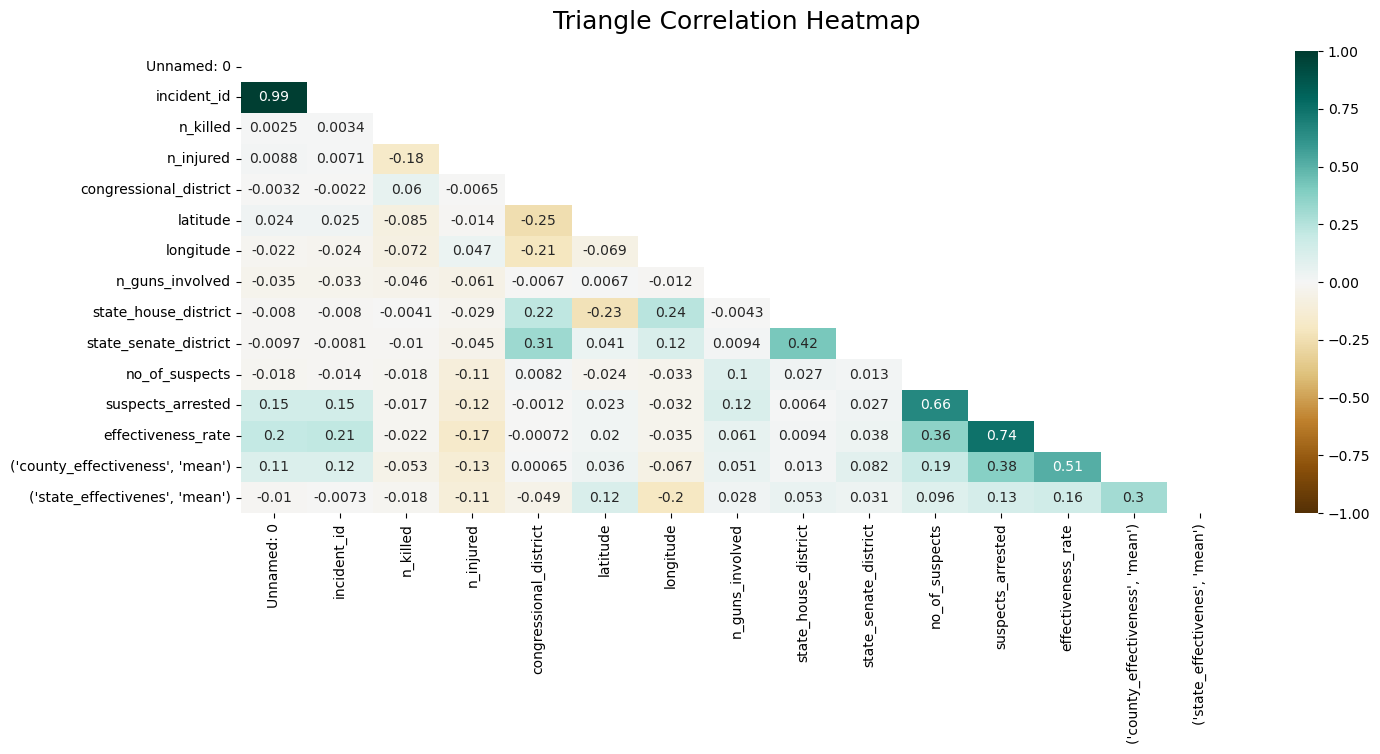

In [24]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Let's have a look on the features that we just added -
- ***no_of_suspects***, we can see that it's partially correlated with number of guns involved (naturally), and a bit partiallly uncorrelated with ***n_injured***.
- ***suspects_arrested***, a bit surprisingly, although intuitive, it's decorrelated as well with ***n_injured***, a way of thinking about that is the more suspects have been arrested, the better the chance the police were able to stop the crime early or before it escalates more.
- ***effectiveness_rate***, only correlated with the former 2, since it's built from them.

But in overall, nothing special seems to be occuring.